In [1]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [2]:
train_file = 'train.parquet'
train_table = pq.read_table(train_file)

train_df = train_table.to_pandas()

In [3]:
train_df.head()

Patient-Uid       Date           Incident
0  a0db1e73-1c7c-11ec-ae39-16262ee38c7f 2019-03-09  PRIMARY_DIAGNOSIS
1  a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f 2015-05-16  PRIMARY_DIAGNOSIS
3  a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f 2018-01-30     SYMPTOM_TYPE_0
4  a0dc950b-1c7c-11ec-b6ec-16262ee38c7f 2015-04-22        DRUG_TYPE_0
8  a0dc9543-1c7c-11ec-bb63-16262ee38c7f 2016-06-18        DRUG_TYPE_1

In [4]:
target_drug = train_df[train_df['Incident'] == 'TARGET DRUG']

In [5]:
grouped_df = target_drug.groupby(by=['Patient-Uid','Date']).count().reset_index()

In [6]:
grouped_df = grouped_df[['Patient-Uid','Date','Incident']]

In [7]:
grouped_df.rename(columns={'Incident':'Target_Drug_Count'}, inplace=True)

grouped_df.head()

Patient-Uid       Date  Target_Drug_Count
0  a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-07-08                  1
1  a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-08-05                  1
2  a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-09-02                  1
3  a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f 2018-04-24                  1
4  a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f 2018-05-17                  1

In [8]:
grouped_df['time_diff'] = grouped_df.groupby('Patient-Uid')['Date'].diff()

In [9]:
grouped_df['total_prescriptions'] = grouped_df.groupby('Patient-Uid')['Target_Drug_Count'].cumsum()

grouped_df.head()

Patient-Uid       Date  Target_Drug_Count  \
0  a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-07-08                  1   
1  a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-08-05                  1   
2  a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-09-02                  1   
3  a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f 2018-04-24                  1   
4  a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f 2018-05-17                  1   

  time_diff  total_prescriptions  
0       NaT                    1  
1   28 days                    2  
2   28 days                    3  
3       NaT                    1  
4   23 days                    2

In [10]:
grouped_df.dropna(subset=["time_diff"], inplace=True)

grouped_df.head()

Patient-Uid       Date  Target_Drug_Count  \
1  a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-08-05                  1   
2  a0e9c384-1c7c-11ec-81a0-16262ee38c7f 2020-09-02                  1   
4  a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f 2018-05-17                  1   
5  a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f 2018-06-13                  1   
6  a0e9c3b3-1c7c-11ec-ae8e-16262ee38c7f 2018-08-07                  1   

  time_diff  total_prescriptions  
1   28 days                    2  
2   28 days                    3  
4   23 days                    2  
5   27 days                    3  
6   55 days                    4

In [1]:
grouped_df['Date'] = pd.to_datetime(grouped_df['Date'])

grouped_df['month'] = grouped_df['Date'].dt.month

grouped_df.head()

In [1]:
monthly_group = grouped_df.groupby(['Patient-Uid','month']).sum().reset_index()

monthly_group = monthly_group.sort_values(by=['Patient-Uid','month'])

monthly_group.head()

In [1]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array(monthly_group[['Target_Drug_Count']])
kmeans = KMeans(n_clusters=3, random_state=7).fit(X)
monthly_group['cluster'] = kmeans.labels_

monthly_group.head()

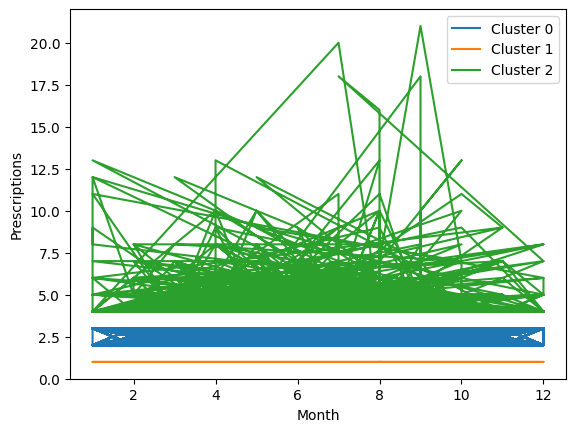

In [26]:
for cluster in np.unique(monthly_group['cluster']):
    cluster_df = monthly_group[monthly_group['cluster'] == cluster]
    plt.plot(cluster_df['month'], cluster_df['Target_Drug_Count'], label=f'Cluster {cluster}')

plt.xlabel('Month')
plt.ylabel('Prescriptions')
plt.legend()
plt.show()
